In [1]:
# default_exp data.load_pd

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *

In [4]:
# hide
from nbdev.showdoc import *

# Data Load Dataframe


> Using the fastai2 `Datasets` to make an time series dataset.

A multivaraite time-series dataloader. 

TODO reduce mem: https://forums.fast.ai/t/how-to-handle-dataframes-too-large-to-fit-in-memory/39208/19

In [5]:
# export
import numpy as np
import pandas as pd

In [6]:
class TSeries(TensorBase):pass

In [7]:
def no_emp_dim(x):
    if len(x.shape)==1 :
        x = x[None,:]
    return np.vstack(x)

def show_graph(array, ax=None, figsize=None, title=None, ctx=None, tx=None, **kwargs):
    "Show an array on `ax`."
    if hasattrs(array, ('data','cpu','permute')):
        array = array.data.cpu()
    elif not isinstance(array,np.ndarray):
        array=array(array)
    arrays = no_emp_dim(array)
    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (5,5)
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    tx = ifnone(tx,np.arange(arrays[0].shape[0]))
    label = kwargs.pop('label', 'x')
    for a, c in zip(arrays, ['b', 'c', 'm', 'y', 'k',]):
        ax.plot(tx, a, '-*'+c,label=label, **kwargs)

    if title is not None: ax.set_title(title)

    ax.legend()
#     ax.axis('off')
    return ax

In [8]:
# export
class TensorSeqs(TSeries):
    
    def show(self, ax = None, ctx=None, **kwargs):
        ctx = ifnone(ctx, ax)
        if ctx is None: _, ctx = plt.subplots(figsize=(5,5))
        array = np.array(self.cpu())
        arrays = no_emp_dim(array)
        m = self._meta.get('m',['b', 'c', 'm', 'y', 'k',][:len(arrays)])
        labels = self._meta.get('label',['x']*len(arrays))
        t = np.arange(array.shape[1])
        
        for a, c, label in zip(arrays, m, labels):            
            mark = '-' if 'y' not in label else ''                
            ctx.plot(t, a, mark + '*' +c, **kwargs, label=label)            #
        ctx.legend()
        return ctx
    

In [9]:
a = torch.cat([i+torch.arange(10)[None,:] for i in [0,2]])

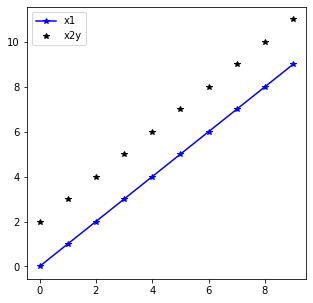

In [10]:
_, ctx = plt.subplots(figsize=[5,5])
ax = TensorSeqs(a, m=['b','k'], label = ['x1','x2y']).show(ctx=ctx)

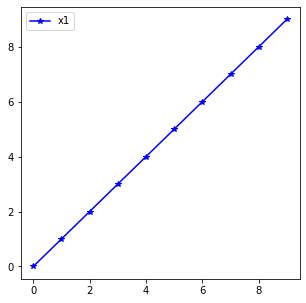

In [11]:
ax = TensorSeqs(torch.arange(10)[None,:], m=['b','k'], label = ['x1','x2']).show()

In [12]:
class TensorCon(TSeries):
    def show(self, ax = None, ctx=None):
        ax = ifnone(ax,ctx)
        if ax is None:
            _, ax = plt.subplots(figsize=(5,5))
        ax.set_title(ax.title._text +f" {self._meta.get('label','con')}: {str(self.data.item())}")
        return ax

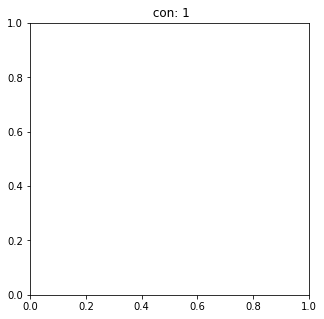

In [13]:
TensorCon(1).show()

## Utils

In [14]:
# export
from typing import List
def same_size_ts(ts:pd.Series, ts_names:List[str]):    
    all_same = [[(ts[c].shape == ts[a].shape) for c in ts_names] for a in ts_names]
    mask = np.array(all_same)    
    return np.sum(mask) == len(ts_names)**2
    

In [15]:
df = pd.DataFrame(data={'ts_0':[pd.Series(np.arange(10)),
                           pd.Series(np.arange(10))],
                   'ts_1':[pd.Series(np.arange(1,11)),
                           pd.Series(np.arange(1,12))],
                   'var_0':[0.,1.],
                   'con_0':[0,1]})
for i, row in df.iterrows():
    if i == 0:
        test_eq(same_size_ts(row,['ts_0','ts_1']),True)
    if i == 1:
        test_eq(same_size_ts(row,['ts_0','ts_1']),False)

In [16]:
# export
def get_part_of_ts(x, lookback_id, length, pad=np.mean):
    if len(x.shape) == 1:
        x = x[None,:]
    if isinstance(x[0,0],int):
        x = x.astype(float)
    if x.shape[-1] < length:
        # If the time series is too short, we pad
        padding = pad(x, -1)
        x = tensor(np.pad(
            x, # report issue https://github.com/numpy/numpy/issues/15606
            pad_width=((0, 0), (length - x.shape[-1], 0)),
            mode='constant',
            constant_values=padding
        )).float()
        assert x.shape == (x.shape[0],length), f"{x.shape}\t,{lookback_id}, 'tsshape':{x.shape}"
    else:
        x = tensor(x[:,lookback_id:lookback_id + length]).float()
    return x


In [17]:
x = np.arange(10)
test_eq(get_part_of_ts(x, 2, 5), torch.arange(2,7.)[None,:])
x = np.arange(10)[None,:]
test_eq(get_part_of_ts(x, 2, 5), torch.arange(2,7.)[None,:])
test_eq(get_part_of_ts(x, 0, 11), tensor([[4., 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))
x = np.vstack([np.arange(10)]*2)
test_eq(get_part_of_ts(x, 2, 5), torch.cat([torch.arange(2,7.)[None,:]]*2))
test_eq(get_part_of_ts(x, 0, 11), tensor([[4., 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                          [4, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

# report issue https://github.com/numpy/numpy/issues/15606
x = np.arange(10)[None,:]
# test_eq(get_part_of_ts(x, 0, 11), tensor([[4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

# Dataloader

In [111]:
# export
@delegates()
class DfDataLoader(TfmdDL):
    def __init__(self, dataset:pd.DataFrame, y_name, horizon, lookback=72, step=1, min_seq_len=None, max_std= 2, norm=True, **kwargs):
        store_attr(self,'horizon,lookback,step,max_std,norm,y_name')
        self.min_seq_len = ifnone(min_seq_len, lookback)
        self.dataset = dataset
        self.con_names, self.cat_names, self.ts_names = L(), L(), L()
        for col in dataset.columns:
            t = type(dataset[col].iloc[0])
            if t is pd.core.series.Series:
                self.ts_names.append(col)
            elif t is np.ndarray:
                self.dataset[col] = pd.Series([pd.Series(o.flatten()) for o in self.dataset[col]])
                self.ts_names.append(col)
            elif isinstance(dataset[col].iloc[0], int) or t is np.int64:
                self.con_names.append(col)
            elif isinstance(dataset[col].iloc[0], float):
                self.cat_names.append(col)
            else:
                raise Exception(t) 
        assert y_name in self.ts_names
        self.ts_names.remove(y_name)
        n = self.make_ids()
        super().__init__(dataset=self.dataset, **kwargs)
        self.n = n
        self.skipped= []
        self.ms = {}        

    @delegates(TfmdDL.new)
    def new(self, dataset=None, cls=None, **kwargs):
        res = super().new(dataset, cls, horizon=self.horizon, lookback=self.lookback, step=self.step , **kwargs)
        res.make_ids()
        return res

    def make_ids(self):
        """Make ids if the sequence is shorter than `min_seq_len`, it will drop that sequence."""
        # Slice each time series into examples, assigning IDs to each
        last_id = 0
        n_dropped = 0
        n_needs_padding = 0
        self._ids = {}
        for i, ts in self.dataset.iterrows(): 
            assert same_size_ts(ts, self.ts_names), f"row {i} are not all the time series the same length"
            num_examples = (ts[self.y_name].shape[-1] - self.lookback - self.horizon + self.step) // self.step
            # Time series shorter than the forecast horizon need to be dropped.
            if ts[self.y_name].shape[-1] < self.min_seq_len:
                n_dropped += 1
                continue
            # For short time series zero pad the input
            if ts[self.y_name].shape[-1] < self.lookback + self.horizon:
                n_needs_padding += 1
                num_examples = 1
            for j in range(num_examples):
                self._ids[last_id + j] = (i, j * self.step)
            last_id += num_examples

        # Inform user about time series that were too short
        if n_dropped > 0:
            print("Dropped {}/{} time series due to length.".format(
                    n_dropped, len(self.dataset)))

        # Inform user about time series that were short
        if n_needs_padding > 0:
            print("Need to pad {}/{} time series due to length.".format(
                    n_needs_padding, len(self.dataset)))
        # Store the number of training examples
        return int(self._ids.__len__() )
    
        def shuffle_fn(self, idxs):
#         self.dataset.shuffle()        
            return idxs

    def get_id(self, idx):
        ts_id, lookback_id = self._ids[idx]
        row = self.dataset.iloc[ts_id, :]
        x = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback)        
        y = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback + self.horizon)
        tsx = np.concatenate([o[None,:] for o in row[self.ts_names].to_numpy()])
        tsx = get_part_of_ts(tsx, lookback_id, self.lookback + self.horizon)
        cat, con = row[self.cat_names].to_numpy().astype(int), row[self.con_names].to_numpy().astype(float)
        return x, tsx, cat, con, y

    def create_item(self, idx):
        if idx>=self.n:
            raise IndexError
        x, tsx, cat, con, y  = self.get_id(idx)
        if (y/(x.std()+1e-7)).std() > self.max_std:
            if idx not in self.skipped:
#                 print(f"idx: {idx};y.std to high: {(y/x.std()).std()} > {self.max_std}")
                self.skipped.append(idx)
            raise SkipItemException()
        
#         print({k:(o,o.dtype,o.shape) for k,o in zip(['x','tsx','cat','con','y'],[x,tsx,cat,con,y])})        
        return (
            TensorSeqs(x, label=[self.y_name + '_x'], m=['g']),
            TensorSeqs(tsx,label=self.ts_names),
            TensorCon(cat,label=self.cat_names).long(),
            TensorCon(con,label=self.con_names),
            TensorSeqs(y, label=[self.y_name+ '_y'], m=['r'])
        )

    

The data will be stored in pandas DataFrames. This can be use for time series by nesting series into a cell. An example is shown below: 

In [112]:
df = pd.DataFrame(data={'pred':[np.arange(10.),
                           np.arange(12.)],
                   'ts_0':[np.ones(10)[None,:],
                           np.ones(12)[None,:]],
                   'ts_1':[pd.Series(np.arange(1,11)+np.random.randn(10)),
                           pd.Series(np.arange(1,13)+np.random.randn(12))],
                   'var_0':[0.,1.],
                   'con_0':[0,1]})
df

,pred,ts_0,ts_1,var_0,con_0
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 -0.047360 1 2.432810 2 1.853505 3 4.041274 4 4.546992 5 7.184111 6 8.470761 7 8.079718 8 9.194248 9 9.550473 dtype: float64,0.0,0
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 1.349989 1 3.404112 2 3.454652 3 2.733100 4 5.572483 5 6.424255 6 6.766699 7 7.691938 8 8.562481 9 8.869173 10 10.953326 11 13.768112 dtype: float64,1.0,1


In [113]:
horizon,lookback = 2,9
dl = DfDataLoader(df, 'pred', horizon = horizon, lookback = lookback)


Need to pad 1/2 time series due to length.


In [114]:
for o in dl:
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'],o)}
    print({k:v.shape for k,v in dct.items()})
    test_eq(dct['x'].shape,(3,1,9))
    break
dl.ts_names

{'x': torch.Size([3, 1, 9]), 'tsx': torch.Size([3, 2, 11]), 'cat': torch.Size([3, 1]), 'con': torch.Size([3, 1]), 'y': torch.Size([3, 1, 11])}


(#2) ['ts_0','ts_1']

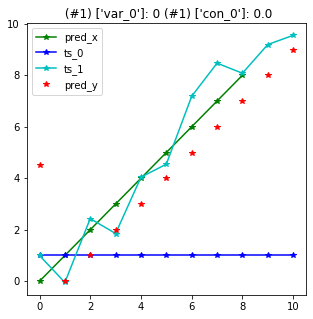

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff762d6bef0>
Traceback (most recent call last):
  File "/home/tako/dev/env37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/tako/dev/env37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/local/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/usr/local/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/local/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


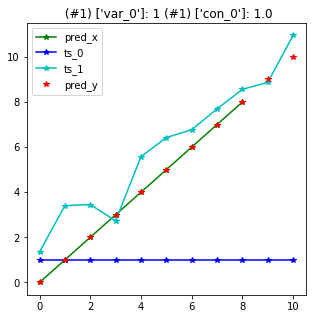

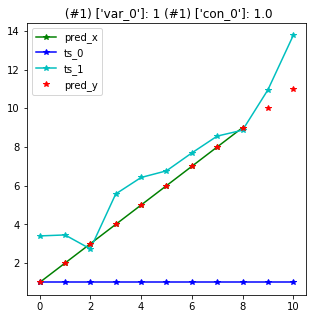

In [115]:
dl.show_batch(max_n=3)

# Intergration Example

In [116]:
from fastseq.data.external import *

In [135]:
horizon,lookback = 5,10
df = dummy_data_generator_multi(32)
df.head()

,x,weather,city,cont
0,"[[-1.8382546902713643, -1.6631399960143547, -1.9269190696561027, -1.3043245146851685, -0.9945664020313525, -0.623055579599974, -0.49676895891149697, -0.5300527532488936, -0.7925425012995, -0.6392606259327083, -0.677009977561514, -0.6324498396256508, -0.24224935251459798, -0.05129699841714007, 0.27492936339390606, 0.24134425015090763, 0.4091425979615187, 0.18827121398452276, 0.05885085453932435, -0.05821117654895804, -0.301235683661033, -0.27600700215860174, 0.2534368586438282, 0.6363672381149441, 0.8964870570527448, 1.1068896697035449, 1.5382836362017105, 1.573542702381081, 1.7009023678139...","[[1.4447736304789591, 1.3762639218226413, 1.6468268245574393, 2.1406273119430814, 2.680899562293949, 3.097668954472762, 3.288463383246069, 3.250024436155506, 3.0702455794161714, 2.8845554618823295, 2.814234925962636, 2.9108617191447173, 3.12877381393802, 3.3369708699699965, 3.3670540807571827, 3.080057780644699, 2.4274116020939474, 1.4826539214252012, 0.43051595792556796, -0.4848952609526269, -1.0362564420502067, -1.0877630654385173, -0.6424651280935996, 0.15478850512072095, 1.0607016286702908, 1.809166690823516, 2.1940271362547863, 2.1313596310107537, 1.680782786083435, 1.0194633400277393...",0,0.034548
1,"[[1.2122562262508338, 0.9757247259588766, 1.1824319388541376, 1.0081959871381956, 0.8291513391714501, 1.4985224177488876, 1.5490802510253858, 1.1957540973819145, 1.1958886455614508, 0.7536429774286688, 0.10501360894302618, -0.3862315751086253, -0.8235685862274607, -1.1560113519056445, -0.8022291693804803, -0.3990190017868308, 0.28108284056401617, 0.8137943975634478, 0.7306925691001112, 0.44722962374170394, -0.012429321995965407, -0.46539133035943964, -1.1348899815968978, -1.6648249763087766, -1.885070977134012, -1.8384283726167583, -1.3749112250868372, -0.7149242083491835, -0.3962097365377...","[[8.662013618271937, 8.333734389983075, 8.237401950047783, 8.487612892273411, 9.074812613799741, 9.863832539383758, 10.637334619131394, 11.169160021571496, 11.301833186118557, 11.000876586145337, 10.366732717394733, 9.600074910458362, 8.932777505664792, 8.548930891005153, 8.52371409047188, 8.801469008142991, 9.220283691637533, 9.573814562968696, 9.687885387898692, 9.48429662586887, 9.009060880514113, 8.41520249482587, 7.90666283375002, 7.66383974596102, 7.777840679660003, 8.217302978706728, 8.839807380346164, 9.443748879808492, 9.841857737884187, 9.929671705228746, 9.724001144154181, 9.357...",0,-0.338240
2,"[[2.3986136309132675, 2.0531146337603756, 1.668033829367856, 1.5346151240099153, 1.1792728914306907, 1.296831430173458, 1.0955133504534842, 0.9852868061261609, 0.6830329058065346, 0.3187305146819001, 0.012757645356272277, -0.305221556447711, -0.5659353292688706, -0.669268713767279, -0.4819134213449456, -0.3503036627955537, -0.23298089628480936, -0.05534748959015042, -0.02792097005700998, -0.13314017616903312, -0.2478735416402717, -0.46316720104674497, -0.7935560412404196, -1.0053906105256987, -1.0431946831577086, -1.1684220966317844, -1.0507355059882642, -0.9231920275021446, -0.97306154609...","[[3.978643340829013, 3.945791927936596, 3.9827570971276014, 4.076838179656565, 4.208955439736811, 4.356435018996844, 4.49627117716086, 4.608353972323107, 4.678159743080302, 4.69849160336414, 4.670012962326325, 4.600513508433099, 4.503052278757441, 4.393303125434899, 4.286554858063285, 4.194871098800349, 4.1248850163710955, 4.076596610775521, 4.043372713288625, 4.013149701752663, 3.9706387665698117, 3.9001660556045303, 3.788672531783835, 3.6283685066414915, 3.418590571025781, 3.1665356110050427, 2.8867272879825276, 2.599275543863963, 2.3271861189252023, 2.093132871537757, 1.9161955374882271...",0,-2.683742
3,"[[-1.5113468190366066, -1.4235026455248934, -1.5416581016384334, -1.6182637684252767, -0.9313976985549955, -0.43274947591052426, -0.456907736118886, -0.008366046133229854, -0.22342582881392525, -0.16785388880451343, -0.6046606217439169, -0.8745346272285208, -1.139578571200989, -1.0176160792812772, -0.7239582725772113, -0.

In [136]:
pd.Series(np.ones(10)).dtype

dtype('float64')

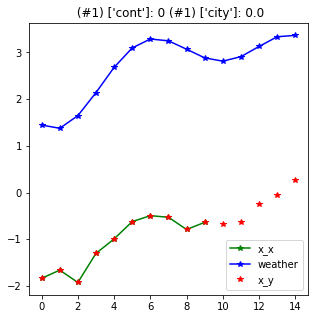

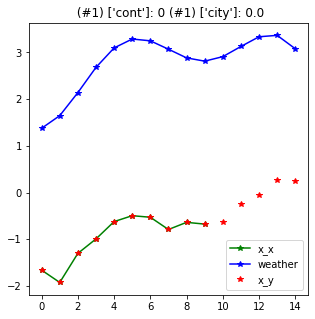

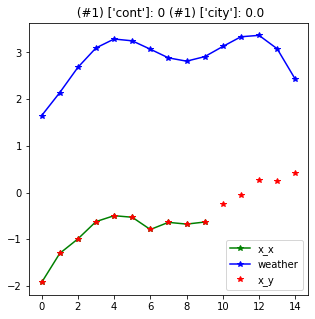

In [137]:
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback)
dl.show_batch(max_n=3)

In [138]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
